In [1]:
#@markdown #**Exploring DQD Algorithms** 🔬

In [2]:
#@markdown #**Check GPU type** 🕵️
#@markdown ### Factory reset runtime if you don't have the desired GPU.

#@markdown ---




#@markdown V100 = Excellent (*Available only for Colab Pro users*)

#@markdown P100 = Very Good

#@markdown T4 = Good (*preferred*)

#@markdown K80 = Meh

#@markdown P4 = (*Not Recommended*) 

#@markdown ---

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5af02c0d-b052-934f-f2ee-7ba92f49e009)


In [3]:
#@markdown #**Install libraries** 🏗️
# @markdown This cell will take around 5 minutes to download several libraries.

#@markdown ---
!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
# !git clone https://github.com/autonomousvision/stylegan_xl
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja
!pip install timm

# !curl -LO 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-1024x1024.pkl'
# !curl -LO 'https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl'
# !curl -LO 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl'
!curl -LO 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl'
!git clone https://github.com/icaros-usc/pyribs.git
!pip install ./pyribs[all]

import sys
sys.path.append("./CLIP")
sys.path.append("./stylegan2-ada-pytorch")
# sys.path.append('./stylegan_xl')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.4 MB/s eta 0:14:40tcmalloc: large alloc 1147494400 bytes == 0x39caa000 @  0x7ff543867615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████▌               | 1055.7 MB 1.3 MB/s eta 0:12:29tcmalloc: large alloc 1434370048 bytes == 0x7e300000 @  0x7ff543867615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████

In [4]:
import io
import os, time, glob
import pickle
import shutil
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files

import csv
import matplotlib.pyplot as plt
import pandas as pd

from ribs.archives import CVTArchive, GridArchive
from ribs.emitters import GradientArborescenceEmitter
from ribs.schedulers import Scheduler
from ribs.visualize import grid_archive_heatmap


In [5]:
def tensor_to_pil_img(img):
    img = (img.clamp(-1, 1) + 1) / 2.0
    img = img[0].permute(1, 2, 0).detach().cpu().numpy() * 255
    img = Image.fromarray(img.astype('uint8'))
    return img

def norm1(prompt):
    return prompt / prompt.square().sum(dim=-1, keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def cos_sim_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().mul(2)

def prompts_dist_loss(x, targets, loss):
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)  

In [6]:
class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

In [7]:
class CLIP(object):
    def __init__(self, device='cpu'):
        self.device = device
        clip_model_name = "ViT-B/32"
        self.model, _ = clip.load(clip_model_name, device=device)
        self.model = self.model.requires_grad_(False)
        self.model.eval()
        self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                              std=[0.26862954, 0.26130258, 0.27577711])

    @torch.no_grad()
    def embed_text(self, prompt):
        return norm1(self.model.encode_text(clip.tokenize(prompt)
               .to(self.device)).float())

    def embed_cutout(self, image):
        return norm1(self.model.encode_image(self.normalize(image)))

    def embed_image(self, image):
        n = image.shape[0]
        cutouts = make_cutouts(image)
        embeds = self.embed_cutout(cutouts)
        embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
        return embeds

In [8]:
class Generator(object):

    def __init__(self, device='cpu'):
        self.device = device
        model_filename = 'metfaces.pkl'
        with open(model_filename, 'rb') as fp:
            self.model = pickle.load(fp)['G_ema'].to(device)
            self.model.eval()
        for p in self.model.parameters():
            p.requires_grad_(False)
        self.init_stats()
        self.latent_shape = (-1, 512)

    def init_stats(self):
        zs = torch.randn([10000, self.model.mapping.z_dim], device=self.device)
        ws = self.model.mapping(zs, None)
        self.w_stds = ws.std(0)
        qs = ((ws - self.model.mapping.w_avg) / self.w_stds).reshape(10000, -1)
        self.q_norm = torch.norm(qs, dim=1).mean() * 0.15

    def gen_random_ws(self, num_latents):
        zs = torch.randn([num_latents, self.model.mapping.z_dim], device=self.device)
        ws = self.model.mapping(zs, None)
        return ws

In [9]:
class Classifier(object):

    def __init__(self, gen_model, class_model, prompt):
        self.device = gen_model.device
        self.gen_model = gen_model
        self.class_model = class_model
        self.measures = []
        self.init_objective(f'A potrait of a {prompt}.')
        self.add_measure(f'A potrait of a {prompt} with long hair.', 
                         f'A potrait of a {prompt} with short hair.')
        self.add_measure(f'A potrait of a young {prompt}.', 
                         f'A potrait of an old {prompt}.')

    def init_objective(self, text_prompt):
        texts = [frase.strip() for frase in text_prompt.split("|") if frase]
        self.obj_targets = [self.class_model.embed_text(text) for text in texts]

    def add_measure(self, positive_text, negative_text):
        texts = [frase.strip() for frase in positive_text.split("|") if frase]
        negative_targets = [self.class_model.embed_text(text) for text in texts]
        
        texts = [frase.strip() for frase in negative_text.split("|") if frase]
        positive_targets = [self.class_model.embed_text(text) for text in texts]
        
        self.measures.append((negative_targets, positive_targets))

    def find_good_start_latent(self, batch_size=16, num_batches=32):
        with torch.inference_mode():
            qs = []
            losses = []
            G = self.gen_model.model
            w_stds = self.gen_model.w_stds
            for _ in range(num_batches):
                q = (G.mapping(torch.randn([batch_size, G.mapping.z_dim], device=self.device),
                    None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
                images = G.synthesis(q * w_stds + G.mapping.w_avg)
                embeds = self.class_model.embed_image(images.add(1).div(2))
                loss = prompts_dist_loss(embeds, self.obj_targets, spherical_dist_loss).mean(0)
                i = torch.argmin(loss)
                qs.append(q[i])
                losses.append(loss[i])
            qs = torch.stack(qs)
            losses = torch.stack(losses)

            i = torch.argmin(losses)
            q = qs[i].unsqueeze(0)

        return q.flatten()

    def generate_image(self, latent_code):
        ws, _ = self.transform_to_w([latent_code])
        images = self.gen_model.model.synthesis(ws, noise_mode='const')
        return images

    def transform_to_w(self, latent_codes):
        qs = []
        ws = []
        for cur_code in latent_codes:
            q = torch.tensor(
                    cur_code.reshape(self.gen_model.latent_shape), 
                    device=self.device,
                    requires_grad=True,
                )
            qs.append(q)
            w = q * self.gen_model.w_stds + self.gen_model.model.mapping.w_avg
            ws.append(w)

        ws = torch.stack(ws, dim=0)
        return ws, qs

    def compute_objective_loss(self, embeds, qs, dim=None):
        loss = prompts_dist_loss(embeds, self.obj_targets, spherical_dist_loss).mean(0)

        diff = torch.max(torch.norm(qs, dim=dim), self.gen_model.q_norm)
        reg_loss = (diff - self.gen_model.q_norm).pow(2)
        loss = loss + 0.1 * reg_loss

        return loss

    def compute_objective(self, sols):
        ws, qs = self.transform_to_w(sols)

        images = self.gen_model.model.synthesis(ws, noise_mode='const')
        embeds = self.class_model.embed_image(images.add(1).div(2))
    
        loss = self.compute_objective_loss(embeds, qs[0])
        loss.backward()

        value = loss.cpu().detach().numpy()
        jacobian = -qs[0].grad.cpu().detach().numpy()
        return value, jacobian.flatten()

    def compute_measure(self, index, sols):
        ws, qs = self.transform_to_w(sols)

        images = self.gen_model.model.synthesis(ws, noise_mode='const')
        embeds = self.class_model.embed_image(images.add(1).div(2))

        measure_targets = self.measures[index]
        pos_loss = prompts_dist_loss(embeds, measure_targets[0], cos_sim_loss).mean(0)
        neg_loss = prompts_dist_loss(embeds, measure_targets[1], cos_sim_loss).mean(0)
        loss = pos_loss - neg_loss
        loss.backward()

        value = loss.cpu().detach().numpy()
        jacobian = qs[0].grad.cpu().detach().numpy()
        return value, jacobian.flatten()

    def compute_measures(self, sols):
    
        values = []
        jacobian = []
        for i in range(len(self.measures)):
            value, jac = self.compute_measure(i, sols)
            values.append(value)
            jacobian.append(jac)

        return np.stack(values, axis=0), np.stack(jacobian, axis=0)

    def compute_all(self, sols):
        with torch.inference_mode():

            ws, qs = self.transform_to_w(sols)
            qs = torch.stack(qs, dim=0)

            images = self.gen_model.model.synthesis(ws, noise_mode='const')
            embeds = self.class_model.embed_image(images.add(1).div(2))
            
            values = []
            loss = self.compute_objective_loss(embeds, qs, dim=(1,2))
            value = loss.cpu().detach().numpy()
            values.append(value)

            for i in range(len(self.measures)):
                measure_targets = self.measures[i]
                pos_loss = prompts_dist_loss(
                        embeds, 
                        measure_targets[0], 
                        cos_sim_loss,
                    ).mean(0)
                neg_loss = prompts_dist_loss(
                        embeds, 
                        measure_targets[1], 
                        cos_sim_loss
                    ).mean(0)
                loss = pos_loss - neg_loss
                value = loss.cpu().detach().numpy()
                values.append(value)

        return np.stack(values, axis=0)

In [10]:
def transform_obj(objs):
    # Remap the objective from minimizing [0, 10] to maximizing [0, 100]
    return (10.0-objs*5.0)*10.0


def create_optimizer(algorithm, classifier, seed):
    """Creates an optimizer based on the algorithm name.

    Args:
        algorithm (str): Name of the algorithm passed into sphere_main.
        classifier (Classifier): The models for the search.
        seed (int): Main seed or the various components.
    Returns:
        Scheduler: A ribs Scheduler for running the algorithm.
    """
    bounds = [(-0.3, 0.3), (-0.3, 0.3)]
    initial_sol = classifier.find_good_start_latent().cpu().detach().numpy()
    dim = len(initial_sol)
    batch_size = 32
    num_emitters = 1
    resolution = 200
    grid_dims = (resolution, resolution)

    # Create archive.
    archive = GridArchive(
        solution_dim = dim,
        dims=grid_dims, 
        ranges=bounds, 
        learning_rate=0.02,
        threshold_min=0.0,
        seed=seed
    )

    # Maintain a passive elitist archive
    passive_archive = GridArchive(
        solution_dim = dim,
        dims=grid_dims,
        ranges=bounds,
        seed=seed
    )

    # Create emitters. Each emitter needs a different seed, so that they do not
    # all do the same thing.
    emitter_seeds = [None] * num_emitters if seed is None else list(
        range(seed, seed + num_emitters))
    emitters = [
        GradientArborescenceEmitter(
            archive=archive,
            x0=initial_sol,
            sigma0=0.01,
            step_size=0.05,
            restart_rule='basic',
            batch_size=batch_size,
            seed=s
        ) for s in emitter_seeds
    ]

    return Scheduler(archive, emitters), passive_archive

In [11]:
def save_heatmap(archive, heatmap_path):
    """Saves a heatmap of the archive to the given path.
    Args:
        archive (GridArchive or CVTArchive): The archive to save.
        heatmap_path: Image path for the heatmap.
    """
    plt.figure(figsize=(8, 6))
    grid_archive_heatmap(archive, vmin=0, vmax=100, cmap="viridis")
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close(plt.gcf())

In [12]:
# Initialization.
#@markdown #**Run the model** 🚀
#@markdown `prompt`: Enter a prompt here to guide the image generation.
#@markdown ---

prompt = "King"#@param {type:"string"}

#@markdown ---
outdir='logs'
            
# Create a shared logging directory for the experiments for this algorithm.
s_logdir = os.path.join(outdir, "cma_maega")
logdir = Path(s_logdir)
outdir = Path(outdir)
if not outdir.is_dir():
    outdir.mkdir()
if not logdir.is_dir():
    logdir.mkdir()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.cuda.empty_cache()

clip_model = CLIP(device=device)
gen_model = Generator(device=device)
classifier = Classifier(gen_model, clip_model, prompt=prompt)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 58.2MiB/s]


Setting up PyTorch plugin "bias_act_plugin"... Done.


In [13]:
#StyleGAN+CLIP LSI experiments.
trials=1
init_pop=100
itrs=500
log_freq=1
log_arch_freq=1000
image_monitor=True
image_monitor_freq=10
seed=None

for trial_id in range(trials):
    print("Running trial", trial_id)
    # Create a directory for this specific trial.
    s_logdir = os.path.join(outdir, "cma_maega", f"trial_{trial_id}")
    logdir = Path(s_logdir)
    if not logdir.is_dir():
        logdir.mkdir()

    # Create a directory for logging intermediate images if the monitor is on.
    if image_monitor:
        image_monitor_freq = max(1, image_monitor_freq)
        gen_output_dir = os.path.join('generations')
        logdir = Path(gen_output_dir)
        if not logdir.is_dir():
            logdir.mkdir()
        gen_output_dir = os.path.join('generations', f"trial_{trial_id}")
        logdir = Path(gen_output_dir)
        if not logdir.is_dir():
            logdir.mkdir()

    # Create a new summary file
    summary_filename = os.path.join(s_logdir, "summary.csv")
    if os.path.exists(summary_filename):
        os.remove(summary_filename)
    with open(summary_filename, 'w') as summary_file:
        writer = csv.writer(summary_file)
        writer.writerow(['Iteration', 'QD-Score', 'Coverage', 'Maximum', 'Average'])
    
    scheduler, passive_archive = create_optimizer(algorithm="cma_maega", classifier=classifier,seed = seed)
    archive = scheduler.archive

    best = -1000
    non_logging_time = 0.0
    for itr in tqdm(range(1, itrs + 1)):
        itr_start = time.time()
        
        sols = scheduler.ask_dqd()
        objs, jacobian_obj = classifier.compute_objective(sols)
        objs = transform_obj(objs)
        best = max(best, max(objs))

        measures, jacobian_measure = classifier.compute_measures(sols)

        jacobian_obj = np.expand_dims(jacobian_obj, axis=0)
        jacobian = np.concatenate((jacobian_obj, jacobian_measure), axis=0)
        jacobian = np.expand_dims(jacobian, axis=0)

        measures = np.transpose(measures) 

        objs = objs.astype(np.float32)
        measures = measures.astype(np.float32)
        jacobian = jacobian.astype(np.float32)

        scheduler.tell_dqd(objs, measures, jacobian)

        # Update the passive elitist archive.
        for i in range(len(sols)):
          passive_archive.add([sols[i]], [objs[i]], [measures[i]])

        sols = scheduler.ask()
        values = classifier.compute_all(sols)
        values = np.transpose(values)

        objs = values[:,0]
        measures = values[:,1:3]

        objs = transform_obj(np.array(objs, dtype=np.float32))
        measures = np.array(measures, dtype=np.float32)
        
        passive_archive.add(sols, objs, measures)
        
        best_gen = max(objs) 
        best = max(best, best_gen)

        scheduler.tell(objs, measures)

        non_logging_time += time.time() - itr_start

        if itr%50 == 0:
          print('best', best, best_gen)

        if image_monitor and itr % image_monitor_freq == 0:
            best_index = np.argmax(objs)
            latent_code = sols[best_index]

            img = classifier.generate_image(latent_code)
            img = tensor_to_pil_img(img)
            img.save(os.path.join(gen_output_dir, f'{itr}.png'))

        # Save the archive at the given frequency.
        # Always save on the final iteration.
        final_itr = itr == itrs
        if (itr > 0 and itr % log_arch_freq == 0) or final_itr:
            # Save a full archive for analysis.
            df = passive_archive.as_pandas(include_solutions = final_itr)
            df.to_pickle(os.path.join(s_logdir, f"archive_{itr:08d}.pkl"))

            # Save a heatmap image to observe how the trial is doing.
            save_heatmap(passive_archive, os.path.join(s_logdir, f"heatmap_{itr:08d}.png"))

        # Update the summary statistics for the archive
        if (itr > 0 and itr % log_freq == 0) or final_itr:
            with open(summary_filename, 'a') as summary_file:
                writer = csv.writer(summary_file)
                stats = passive_archive.stats
                qd_score = stats.qd_score
                average = stats.obj_mean
                coverage = stats.coverage
                data = [itr, qd_score, coverage, best, average]
                writer.writerow(data)

Running trial 0
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


  0%|          | 0/500 [00:00<?, ?it/s]

best 56.228695 55.89612
best 56.374573 50.306015
best 56.374573 55.774406
best 56.374573 53.968643
best 56.374573 54.174606
best 56.374573 55.647396
best 56.374573 -146.05255
best 56.374573 54.96289
best 56.374573 53.72399
best 56.374573 55.384216


0 4 64 72 120 135
64 <= measure_0 & measure_0 <= 72 &120 <= measure_1 & measure_1 <= 135
1 4 72 81 120 135
72 <= measure_0 & measure_0 <= 81 &120 <= measure_1 & measure_1 <= 135
2 4 81 90 120 135
81 <= measure_0 & measure_0 <= 90 &120 <= measure_1 & measure_1 <= 135
3 4 90 99 120 135
90 <= measure_0 & measure_0 <= 99 &120 <= measure_1 & measure_1 <= 135
4 4 99 108 120 135
99 <= measure_0 & measure_0 <= 108 &120 <= measure_1 & measure_1 <= 135
5 4 108 117 120 135
108 <= measure_0 & measure_0 <= 117 &120 <= measure_1 & measure_1 <= 135
6 4 117 126 120 135
117 <= measure_0 & measure_0 <= 126 &120 <= measure_1 & measure_1 <= 135
7 4 126 135 120 135
126 <= measure_0 & measure_0 <= 135 &120 <= measure_1 & measure_1 <= 135
0 3 64 72 106 120
64 <= measure_0 & measure_0 <= 72 &106 <= measure_1 & measure_1 <= 120
1 3 72 81 106 120
72 <= measure_0 & measure_0 <= 81 &106 <= measure_1 & measure_1 <= 120
2 3 81 90 106 120
81 <= measure_0 & measure_0 <= 90 &106 <= measure_1 & measure_1 <= 120
3 3 90 

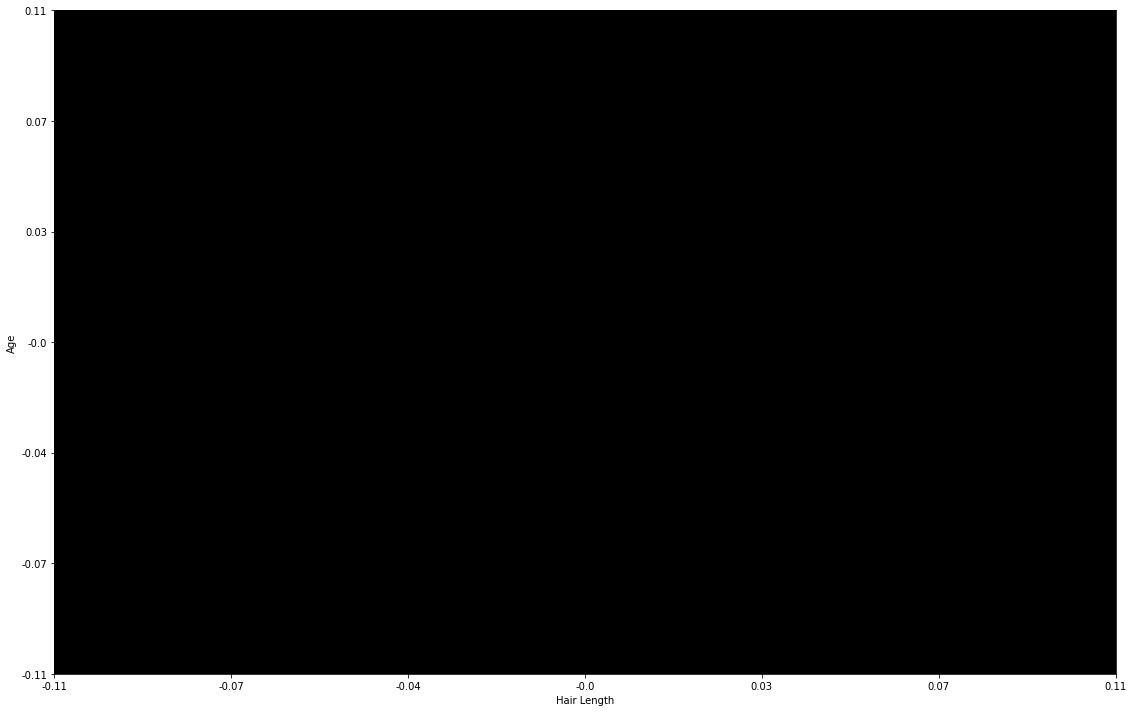

In [15]:
archive_filename = '/content/logs/cma_maega/trial_0/archive_00000500.pkl'

# min and max index for rows then columns (row major).
# The archive is shape (200, 200) indexed from [0, 200).
archive_dims = (200, 200)
archive_index_range = ((64, 135), (64, 135))
# Measure ranges
measure_ranges = ((-0.3, 0.3), (-0.3, 0.3))
# Controls that x rows and y columns are generated
# Images are "evenly" (as possible) sampled based on this criteria
picture_frequency = (8, 5) 

# Use the CPU while we are running exps.
#device = "cpu"
device = "cuda"

# Uncomment to save all grid images separately.
gen_output_dir = os.path.join('grid_imgs')
logdir = Path(gen_output_dir)
if not logdir.is_dir():
    logdir.mkdir()

model_filename = 'metfaces.pkl'
with open(model_filename, 'rb') as fp:
    model = pickle.load(fp)['G_ema'].to(device)
    model.eval()
latent_shape = (1, -1, 512)

zs = torch.randn([10000, model.mapping.z_dim], device=device)
ws = model.mapping(zs, None)
w_stds = ws.std(0)
qs = ((ws - model.mapping.w_avg) / w_stds).reshape(10000, -1)
q_norm = torch.norm(qs, dim=1).mean() * 0.1

# Read the archive from the log (pickle file)
df = pd.read_pickle(archive_filename)

imgs = []
for j in reversed(range(picture_frequency[1])):
    for i in range(picture_frequency[0]):
        
        delta_i = archive_index_range[0][1] - archive_index_range[0][0]
        delta_j = archive_index_range[1][1] - archive_index_range[1][0]
        index_i_lower = int(delta_i * i / picture_frequency[0] + archive_index_range[0][0])
        index_i_upper = int(delta_i * (i+1) / picture_frequency[0] + archive_index_range[0][0])
        index_j_lower = int(delta_j * j / picture_frequency[1] + archive_index_range[1][0])
        index_j_upper = int(delta_j * (j+1) / picture_frequency[1] + archive_index_range[1][0])
        print(i, j, index_i_lower, index_i_upper, index_j_lower, index_j_upper)

        query_string = f"{index_i_lower} <= measure_0 & measure_0 <= {index_i_upper} &"
        query_string += f"{index_j_lower} <= measure_1 & measure_1 <= {index_j_upper}" 
        print(query_string)
        df_cell = df.query(query_string)
        
        if not df_cell.empty:

            sol = df_cell.iloc[df_cell['objective'].argmax()]
            print(sol)

            q = torch.tensor(
                    sol[5:].values.reshape(latent_shape),
                    device=device,
                    requires_grad=True,
                )
            w = q * w_stds + model.mapping.w_avg

            img = model.synthesis(w, noise_mode='const')
            img = (img.clamp(-1, 1) + 1) / 2.0 # Normalize from [0,1]

            # Uncomment to save all grid images separately.
            pil_img = img[0].permute(1, 2, 0).detach().cpu().numpy() * 255
            pil_img = Image.fromarray(pil_img.astype('uint8'))
            pil_img.save(os.path.join(gen_output_dir, f'{j}_{i}.png'))

            img = img[0].detach().cpu()
            imgs.append(img)
        else:
            imgs.append(torch.zeros((3,1024,1024)))

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

plt.figure(figsize=(16,10))
img_grid = make_grid(imgs, nrow=picture_frequency[0], padding=0)
img_grid = np.transpose(img_grid.cpu().numpy(), (1,2,0))
plt.imshow(img_grid)

plt.xlabel("Hair Length")
plt.ylabel("Age")

def create_archive_tick_labels(axis_range, measure_range, dim, num_ticks):
    low_pos = axis_range[0] / dim
    high_pos = axis_range[1] / dim

    tick_offset = [
        (high_pos - low_pos) * (p / num_ticks) + low_pos
        for p in range(num_ticks+1) 
    ]
    ticklabels = [
        round((measure_range[1]-measure_range[0]) * p + measure_range[0], 2)
        for p in tick_offset
    ]
    return ticklabels

num_x_ticks = 6
num_y_ticks = 6
x_ticklabels = create_archive_tick_labels(archive_index_range[0], 
                    measure_ranges[0], archive_dims[0], num_x_ticks)
y_ticklabels = create_archive_tick_labels(archive_index_range[1],
                    measure_ranges[1], archive_dims[1], num_y_ticks)
y_ticklabels.reverse()

x_tick_range = img_grid.shape[1]
x_ticks = np.arange(0, x_tick_range+1e-9, step=x_tick_range/num_x_ticks)
y_tick_range = img_grid.shape[0]
y_ticks = np.arange(0, y_tick_range+1e-9, step=y_tick_range/num_y_ticks)
plt.xticks(x_ticks, x_ticklabels)
plt.yticks(y_ticks, y_ticklabels)
plt.tight_layout()
plt.savefig('collage.pdf')

In [18]:
!zip -r images.zip '/content/generations/trial_0' 

  adding: content/generations/trial_0/ (stored 0%)
  adding: content/generations/trial_0/460.png (deflated 0%)
  adding: content/generations/trial_0/410.png (deflated 0%)
  adding: content/generations/trial_0/210.png (deflated 0%)
  adding: content/generations/trial_0/150.png (deflated 0%)
  adding: content/generations/trial_0/370.png (deflated 0%)
  adding: content/generations/trial_0/140.png (deflated 0%)
  adding: content/generations/trial_0/470.png (deflated 0%)
  adding: content/generations/trial_0/330.png (deflated 0%)
  adding: content/generations/trial_0/250.png (deflated 0%)
  adding: content/generations/trial_0/230.png (deflated 0%)
  adding: content/generations/trial_0/280.png (deflated 0%)
  adding: content/generations/trial_0/240.png (deflated 0%)
  adding: content/generations/trial_0/90.png (deflated 0%)
  adding: content/generations/trial_0/60.png (deflated 0%)
  adding: content/generations/trial_0/310.png (deflated 0%)
  adding: content/generations/trial_0/480.png (defl